In [ ]:
#export
from local.torch_basics import *
from local.test import *
from local.layers import *
from local.data.all import *
from local.notebook.showdoc import show_doc
from local.optimizer import *
from local.learner import *
from local.callback.progress import *
from local.vision.core import *

In [ ]:
#default_exp callback.mixup

# Mixup callback

> Callback to apply MixUp data augmentation to your training

In [ ]:
from local.utils.test import *

## MixupCallback -

In [ ]:
# export
def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss

In [ ]:
a,b = (1,),(2,)
tuple(x+y for x,y in zip(a,b))

(3,)

In [ ]:
# export
from torch.distributions.beta import Beta

class MixUp(Callback):
    run_after=[Normalize, Cuda]
    def __init__(self, alpha=0.4): self.distrib = Beta(tensor([alpha]), tensor([alpha]))

    def begin_fit(self): self.old_loss_func,self.learn.loss_func = self.learn.loss_func,self.loss_func

    def begin_batch(self):
        if not self.training: return #Only mixup things during training
        lam = self.distrib.sample((self.y.size(0),)).squeeze().to(self.x.device)
        lam = torch.stack([lam, 1-lam], 1)
        self.lam = lam.max(1)[0][:,None,None,None]
        shuffle = torch.randperm(self.y.size(0)).to(self.x.device)
        xb1,self.yb1 = tuple(x[shuffle] for x in self.xb),tuple(y[shuffle] for y in self.yb)
        self.learn.xb = tuple(torch.lerp(x1, x, self.lam) for x,x1 in zip(self.xb, xb1))

    def after_fit(self): self.run.loss_func = self.old_loss_func

    def loss_func(self, pred, *yb):
        if not self.in_train: return self.old_loss_func(pred, *yb)
        with NoneReduce(self.old_loss_func) as loss_func:
            loss1 = loss_func(pred, *yb)
            loss2 = loss_func(pred, *self.yb1)
        loss = torch.lerp(loss2, loss1, self.lam)
        return reduce_loss(loss, getattr(self.old_loss_func, 'reduction', 'mean'))

In [ ]:
#test on mnist
from local.vision.core import *

path = untar_data(URLs.MNIST_TINY)
items = get_image_files(path)
tds = DataSource(items, [PILImageBW.create, [parent_label, Categorize()]], splits=GrandparentSplitter()(items))
dbunch = tds.databunch(after_item=[ToTensor(), ByteToFloatTensor()])

In [ ]:
learn = Learner(dbunch, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=MixUp())
learn._do_begin_fit(1)
learn.epoch,learn.training = 0,True
learn.dl = dbunch.train_dl
b = dbunch.one_batch()
learn._split(b)
learn('begin_batch')

In [ ]:
mixup = learn.cbs[-1]

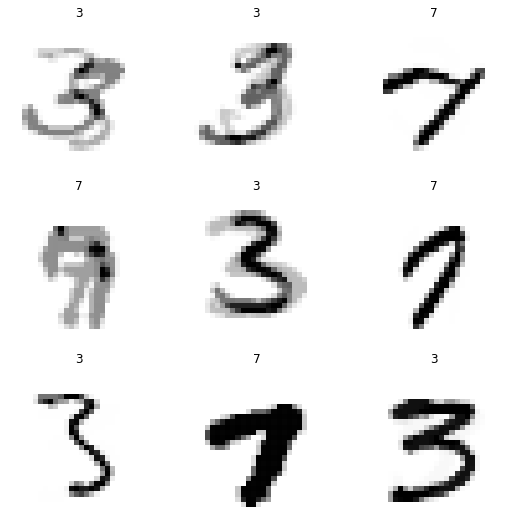

In [ ]:
_,axs = plt.subplots(3,3, figsize=(9,9))
dbunch.show_batch(b=(mixup.x,mixup.y), ctxs=axs.flatten())

## Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 01a_torch_core.ipynb.
Converted 02_script.ipynb.
Converted 03_dataloader.ipynb.
Converted 04_transform.ipynb.
Converted 05_data_core.ipynb.
Converted 06_data_transforms.ipynb.
Converted 07_vision_core.ipynb.
Converted 08_pets_tutorial.ipynb.
Converted 09_vision_augment.ipynb.
Converted 11_layers.ipynb.
Converted 11a_vision_models_xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_learner.ipynb.
Converted 14_callback_schedule.ipynb.
Converted 15_callback_hook.ipynb.
Converted 16_callback_progress.ipynb.
Converted 17_callback_tracker.ipynb.
Converted 18_callback_fp16.ipynb.
Converted 19_callback_mixup.ipynb.
Converted 20_metrics.ipynb.
Converted 21_tutorial_imagenette.ipynb.
Converted 22_vision_learner.ipynb.
Converted 23_tutorial_transfer_learning.ipynb.
Converted 30_text_core.ipynb.
Converted 31_text_data.ipynb.
Converted 32_text_models_awdlstm.ipynb.
Converted 33_text_models_core.ipynb.
Converted 34_callback_rnn.ipynb.